In [19]:
import pandas as pd
import pandas_datareader.data as web
import io
import numpy as np
import requests
import time
import datetime
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [20]:
#function to get stock data
def yahoo_stocks(symbol, start, end):
    return web.DataReader(symbol, 'yahoo', start, end)

In [48]:
#get 7 year stock data for Apple
# startDate = datetime.datetime(2010, 1, 4)
# endDate = datetime.date.today()
startDate = datetime.datetime(2010, 1, 4)
endDate = datetime.date.today()
print (endDate)
stockData = yahoo_stocks('AAPL', startDate, endDate)

2017-12-01


In [49]:
# stock_symbols = ['GOOGL', 'INTU', 'BAC', 'C', 'PTR', 'MSFT', 'FIT', 'DWDP', 'LNKD', 'TWTR', \
#                  'NVDA', 'SYMC', 'PYPL', 'BP']
# for symbol in stock_symbols:
#     data = yahoo_stocks('FB', startDate, endDate)
#     print (data)
#     data.to_csv(symbol+'.csv', sep=',', encoding='utf-8')

In [50]:
print (stockData)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2010-01-04   30.490000   30.642857   30.340000   30.572857   27.406532   
2010-01-05   30.657143   30.798571   30.464285   30.625713   27.453915   
2010-01-06   30.625713   30.747143   30.107143   30.138571   27.017223   
2010-01-07   30.250000   30.285715   29.864286   30.082857   26.967278   
2010-01-08   30.042856   30.285715   29.865715   30.282858   27.146566   
2010-01-11   30.400000   30.428572   29.778572   30.015715   26.907093   
2010-01-12   29.884285   29.967142   29.488571   29.674286   26.601023   
2010-01-13   29.695715   30.132856   29.157143   30.092857   26.976244   
2010-01-14   30.015715   30.065714   29.860001   29.918571   26.820007   
2010-01-15   30.132856   30.228571   29.410000   29.418571   26.371792   
2010-01-19   29.761429   30.741428   29.605715   30.719999   27.538433   
2010-01-20   30.701429   30.792856   2

In [51]:
stockMarketData = yahoo_stocks('^GSPC', startDate, endDate)

In [54]:
stockMarketData.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [55]:
#adding rows for missing dates
def add_missing_dates(dataframe, start, end):
    idx = pd.date_range(start, end)
    dataframe.index = pd.DatetimeIndex(dataframe.index)
    dataframe = dataframe.reindex(idx, fill_value='np.nan')
    return dataframe

In [56]:
stockData = add_missing_dates(stockData, startDate, endDate)

In [57]:
stockData.head(10)

,Open,High,Low,Close,Adj Close,Volume
2010-01-04,30.49,30.6429,30.34,30.5729,27.4065,123432400
2010-01-05,30.6571,30.7986,30.4643,30.6257,27.4539,150476200
2010-01-06,30.6257,30.7471,30.1071,30.1386,27.0172,138040000
2010-01-07,30.25,30.2857,29.8643,30.0829,26.9673,119282800
2010-01-08,30.0429,30.2857,29.8657,30.2829,27.1466,111902700
2010-01-09,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
2010-01-10,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
2010-01-11,30.4,30.4286,29.7786,30.0157,26.9071,115557400
2010-01-12,29.8843,29.9671,29.4886,29.6743,26.601,148614900
2010-01-13,29.6957,30.1329,29.1571,30.0929,26.9762,151473000


In [58]:
stockMarketData = add_missing_dates(stockMarketData, startDate, endDate)

In [59]:
stockMarketData.head(10)

,Open,High,Low,Close,Adj Close,Volume
2010-01-04,1116.56,1133.87,1116.56,1132.99,1132.99,3991400000
2010-01-05,1132.66,1136.63,1129.66,1136.52,1136.52,2491020000
2010-01-06,1135.71,1139.19,1133.95,1137.14,1137.14,4972660000
2010-01-07,1136.27,1142.46,1131.32,1141.69,1141.69,5270680000
2010-01-08,1140.52,1145.39,1136.22,1144.98,1144.98,4389590000
2010-01-09,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
2010-01-10,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan
2010-01-11,1145.96,1149.74,1142.02,1146.98,1146.98,4255780000
2010-01-12,1143.81,1143.81,1131.77,1136.22,1136.22,4716160000
2010-01-13,1137.31,1148.4,1133.18,1145.68,1145.68,4170360000


In [60]:
#convert the columns to numeric
def convert_to_numeric(dataframe):
    for col in dataframe:
        dataframe[col] = pd.to_numeric(dataframe[col], errors='coerce')
    return dataframe

In [61]:
stockDataNumeric = convert_to_numeric(stockData)

In [62]:
stockMarketDataNumeric = convert_to_numeric(stockMarketData)

In [63]:
def interpolate(dataframe):
    features = list(dataframe)
    for feature in features:
        dataframe[feature] = dataframe[feature].interpolate()
    return dataframe

In [64]:
stockDataInterpolated = interpolate(stockDataNumeric)

In [68]:
stockDataInterpolated.tail(5)

,Open,High,Low,Close,Adj Close,Volume
2017-11-27,175.050003,175.080002,173.339996,174.089996,174.089996,20716800.0
2017-11-28,174.300003,174.869995,171.860001,173.070007,173.070007,26428800.0
2017-11-29,172.630005,172.919998,167.160004,169.479996,169.479996,41666400.0
2017-11-30,170.429993,172.139999,168.440002,171.850006,171.850006,41527200.0
2017-12-01,169.949997,171.669998,168.500000,171.050003,171.050003,39726100.0


In [69]:
stockMarketDataInterpolated = interpolate(stockMarketDataNumeric)

In [70]:
stockMarketDataInterpolated.head(10)

,Open,High,Low,Close,Adj Close,Volume
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09
2010-01-09,1142.333334,1146.840007,1138.153321,1145.646647,1145.646647,4.344987e+09
2010-01-10,1144.146647,1148.289998,1140.086670,1146.313313,1146.313313,4.300383e+09
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4.255780e+09
2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4.716160e+09
2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4.170360e+09


In [71]:
#difference between the previous day and todays closing value
def prev_diff(dataframe):
    close = dataframe['Close']
    prev_diff = [0]
    for i in range(1, len(dataframe)):
        prev_diff.append(round((close[i]-close[i-1]),6))
    return prev_diff

In [72]:
stockDataInterpolated['prev_diff'] = prev_diff(stockDataInterpolated)

In [73]:
stockMarketDataInterpolated['sm_prev_diff'] = prev_diff(stockMarketDataInterpolated)

In [74]:
stockMarketDataInterpolated.columns = ['sm_open', 'sm_high', 'sm_low', 'sm_close', 'sm_adj_close', 'sm_volume', 'sm_prev_diff']

In [306]:
finalData = pd.concat([stockDataInterpolated, stockMarketDataInterpolated], axis=1)

In [307]:
finalData.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039


In [308]:
finalData.columns

Index([u'Open', u'High', u'Low', u'Close', u'Adj Close', u'Volume',
       u'prev_diff', u'sm_open', u'sm_high', u'sm_low', u'sm_close',
       u'sm_adj_close', u'sm_volume', u'sm_prev_diff'],
      dtype='object')

In [310]:
temp = finalData.copy()
temp["20d"] = np.round(temp["Close"].rolling(window = 20, center = False).mean(), 2)
z = temp['Close'][0:19]
temp['20d'][0:19] = z

In [311]:
temp["50d"] = np.round(temp["Close"].rolling(window = 50, center = False).mean(), 2)
z = temp['Close'][0:49]
temp['50d'][0:49] = z

In [312]:
temp1 = temp.reset_index()
temp1.drop('index', axis=1, inplace=True)

In [313]:
temp1.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,20d,50d
0,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857,30.572857
1,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713,30.625713
2,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571,30.138571
3,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857,30.082857
4,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858,30.282858


In [314]:
df = temp1
y = temp1['Close'][1:]

In [315]:
today = df.iloc[-1]
df = df.iloc[:-1]

In [316]:
df.shape

(2888, 16)

In [317]:
y.shape

(2888,)

In [318]:
index = int(np.floor(df.shape[0]*0.95))
X_train, X_test = df[:index], df[index:]
y_train, y_test = y[:index], y[index:]
print('Size of train set: ', X_train.shape)
print('Size of test set: ', X_test.shape)
print('Size of train set: ', y_train.shape)
print('Size of test set: ', y_test.shape)

('Size of train set: ', (2743, 16))
('Size of test set: ', (145, 16))
('Size of train set: ', (2743,))
('Size of test set: ', (145,))


In [348]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit(X_train))
StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_transform = scaler.transform(X_train)
X_test_transform = scaler.transform(X_test)

scaler_y = StandardScaler()
scaler_y.fit(y_train.reshape(-1,1))
y_train_transform = scaler_y.transform(y_train.reshape(-1,1))
y_test_transform = scaler_y.transform(y_test.reshape(-1,1))

StandardScaler(copy=True, with_mean=True, with_std=True)


/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()
/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


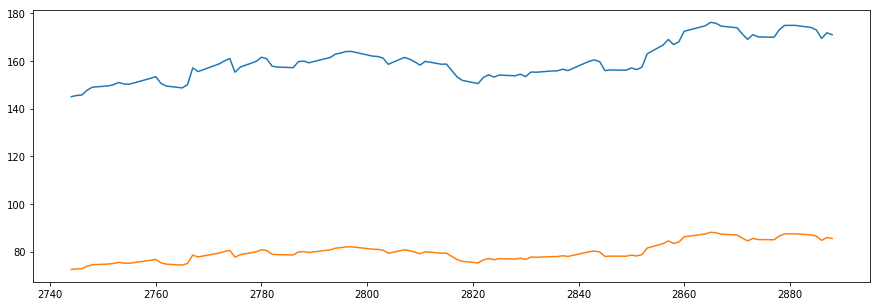

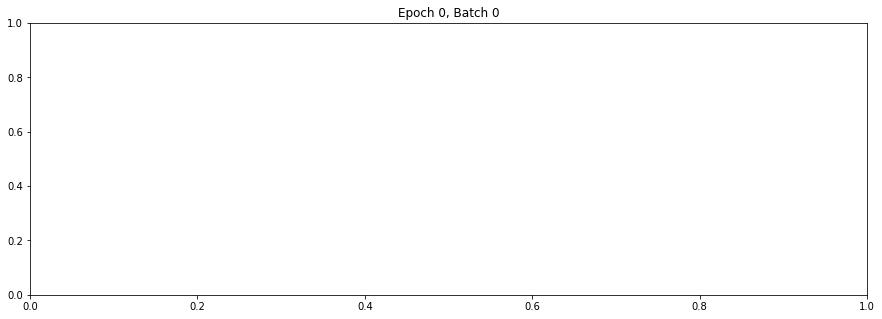

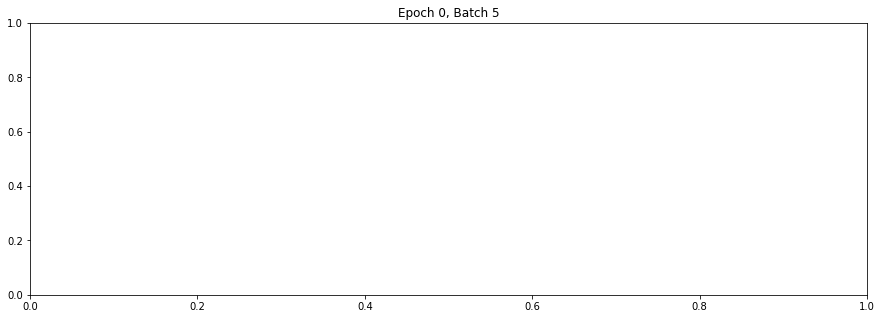

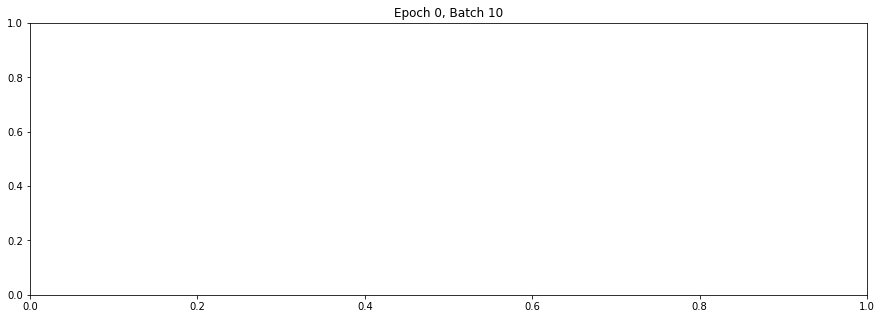

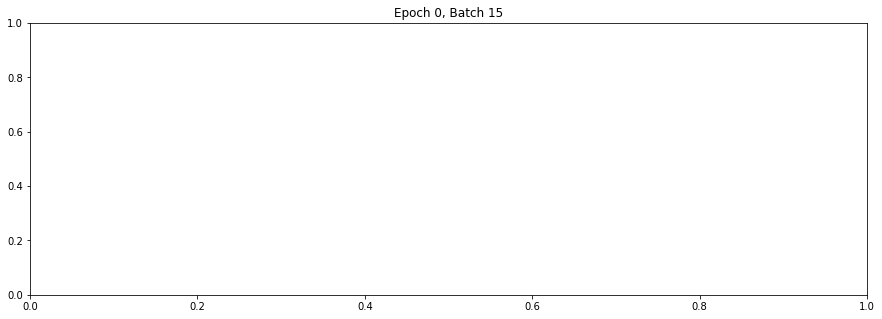

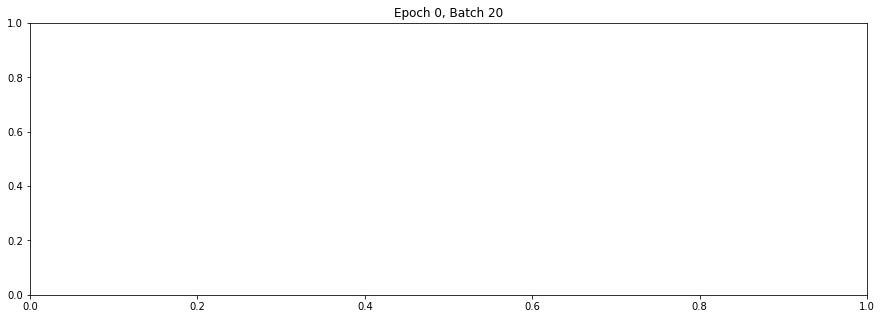

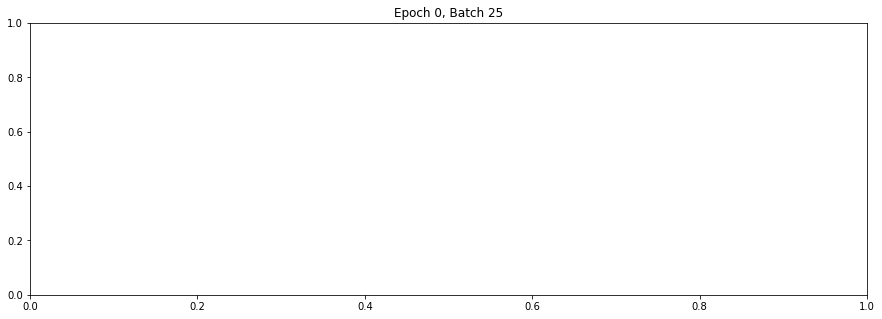

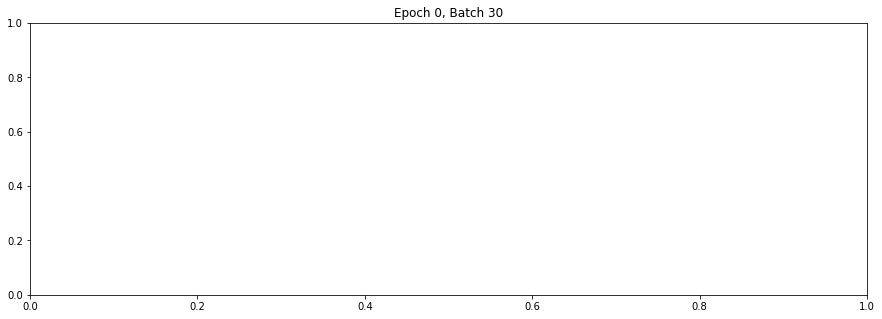

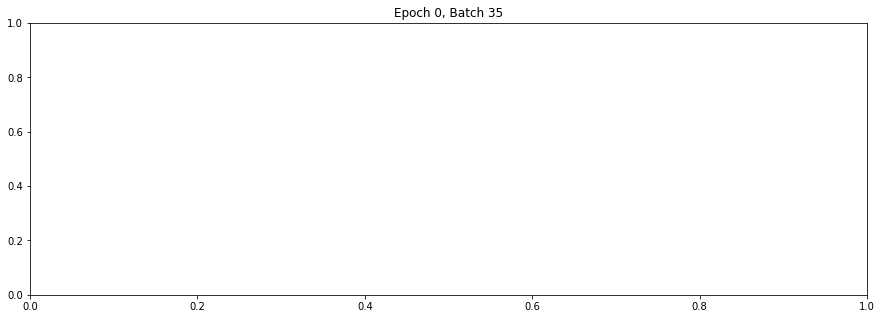

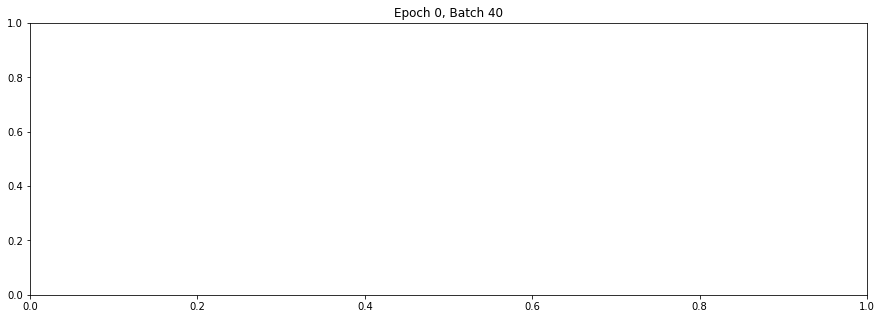

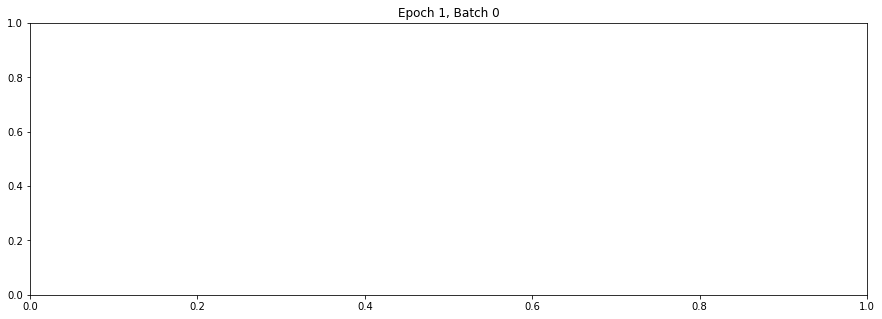

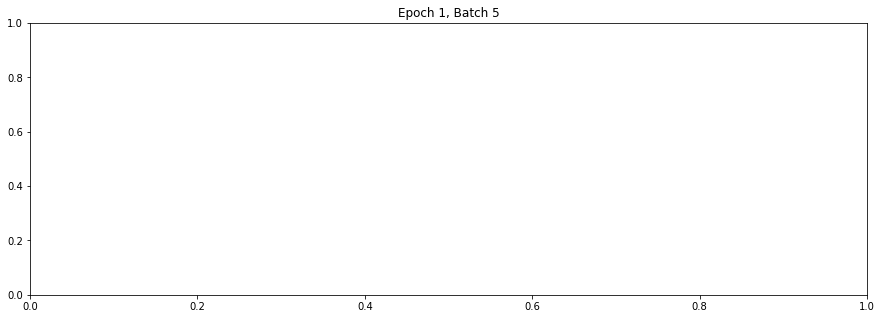

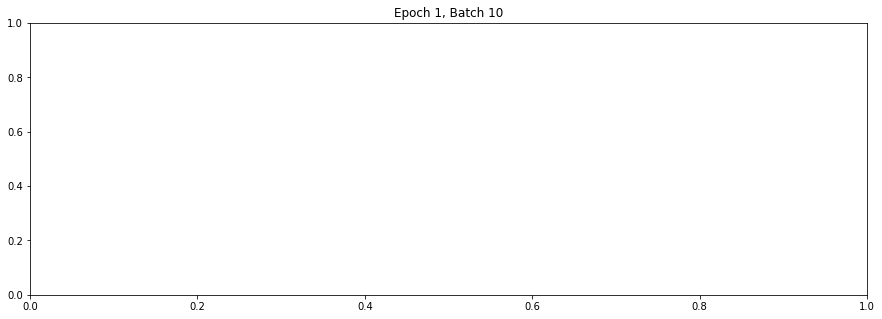

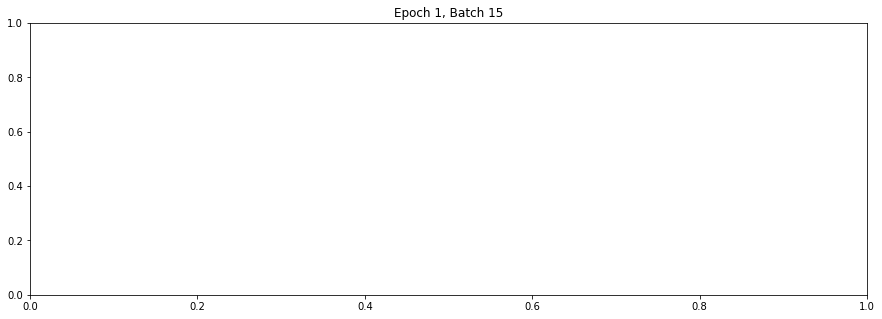

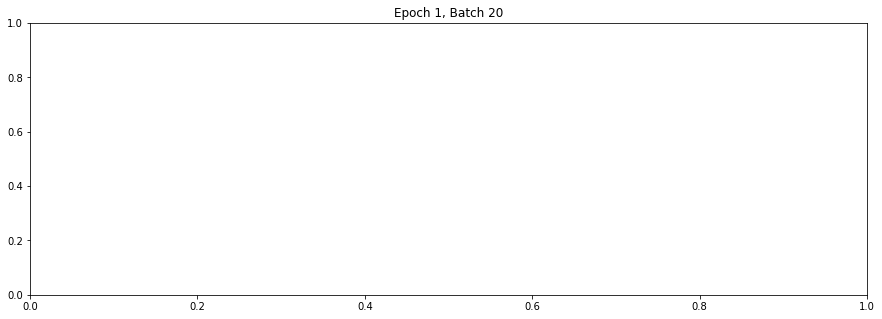

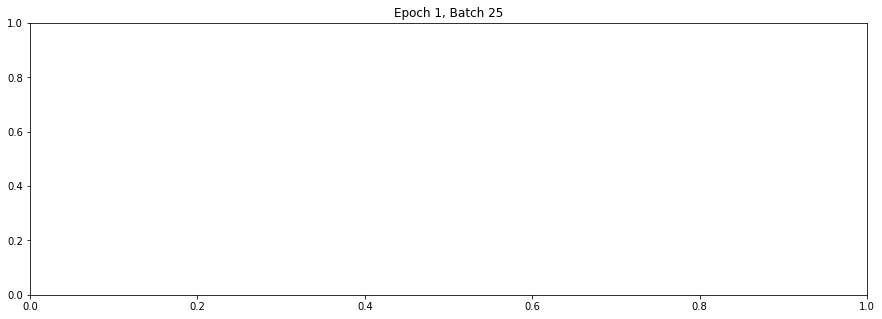

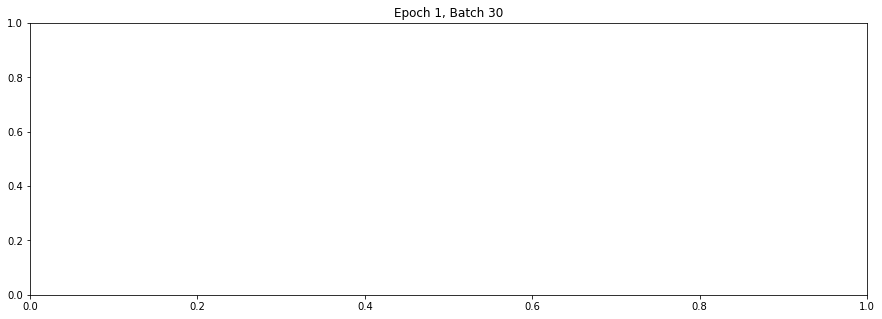

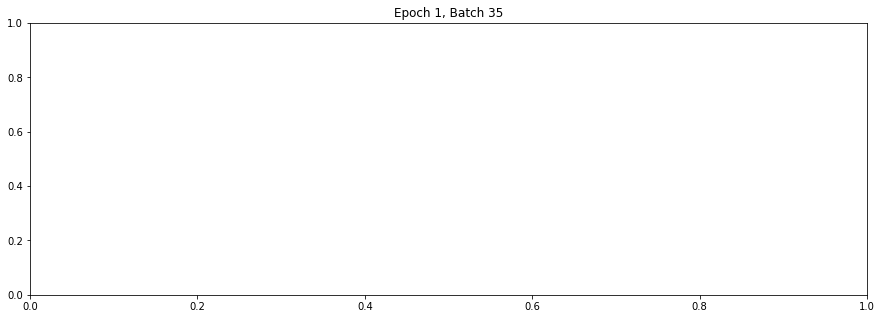

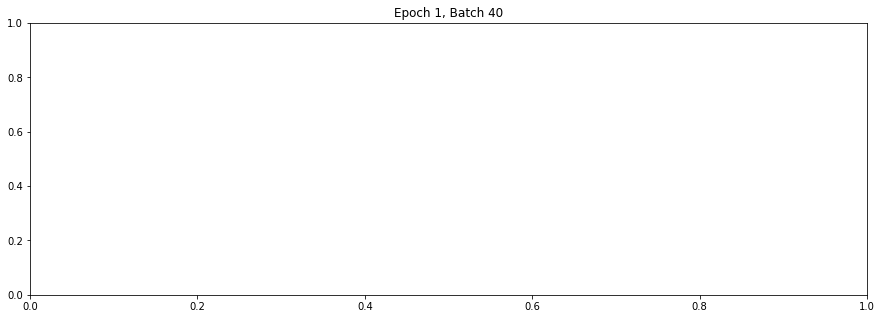

8.80854e+11


In [379]:
import tensorflow as tf


# Model architecture parameters
n_stocks = 16
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128
n_neurons_5 = 64
n_target = 1

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()
# Layer 1: Variables for hidden weights and biases
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
# Layer 2: Variables for hidden weights and biases
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
# Layer 3: Variables for hidden weights and biases
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
# Layer 4: Variables for hidden weights and biases
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))
# Layer 5: Variables for hidden weights and biases
W_hidden_5 = tf.Variable(weight_initializer([n_neurons_4, n_neurons_5]))
bias_hidden_5 = tf.Variable(bias_initializer([n_neurons_5]))

# Output layer: Variables for output weights and biases
W_out = tf.Variable(weight_initializer([n_neurons_5, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))
hidden_5 = tf.nn.relu(tf.add(tf.matmul(hidden_4, W_hidden_5), bias_hidden_5))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_5, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()

# Number of epochs and batch size
epochs = 2
batch_size = 64

for e in range(epochs):

    # Shuffle training data
#     shuffle_indices = np.random.permutation(np.arange(len(y_train)))
#     X_train = X_train[shuffle_indices]
#     y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 5) == 0:
            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            line2.set_ydata(pred)
            plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
#             file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.png'
#             plt.savefig(file_name)
            plt.pause(0.01)
            
# print ("Prediction for tomorrow")
#stockData_predict_array_fit_reshape = stockData_predict_array_fit.reshape(1,7)
#print (stockData_predict_array_fit_reshape.shape)
# pred1 = net.run(out, feed_dict={X: stockData_predict_array_fit})

# print (pred1)

# pred_rescaled = (pred1* (y_train_max - y_train_min)) + (y_train_min)

# print (pred_rescaled)

#real_prediction = y_scaler.inverse_transform(pred1)
#print (real_prediction)
#pred1_reshape = pred1.reshape(1,-1)
#pred1_reshape = pred1_reshape[0].reshape(1,8)
#print (pred1)
#print (pred1_reshape)
#print (scaler.inverse_transform(pred1_reshape))
    
#mse_final1 = net.run(mse, feed_dict={X: stockData_predict, Y: y_test})
# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)



In [366]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

# regr = RandomForestRegressor(n_estimators=1, random_state = 10, min_samples_split=2)
# regr.fit(X_train, y_train)

# regr = GradientBoostingRegressor()
regr = RandomForestRegressor(n_estimators=1, min_samples_split=2, random_state = 5, max_depth=9)
regr.fit(X_train_transform, y_train_transform)

/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=5, verbose=0, warm_start=False)

In [367]:
predictions = regr.predict(X_test_transform)

In [374]:
from sklearn.metrics import mean_squared_error

actual = scaler_y.inverse_transform(predictions)
error = mean_squared_error(y_test, actual)
error

79.649226951653375

In [373]:
y_t = []
for item in y_test:
    y_t.append(item)

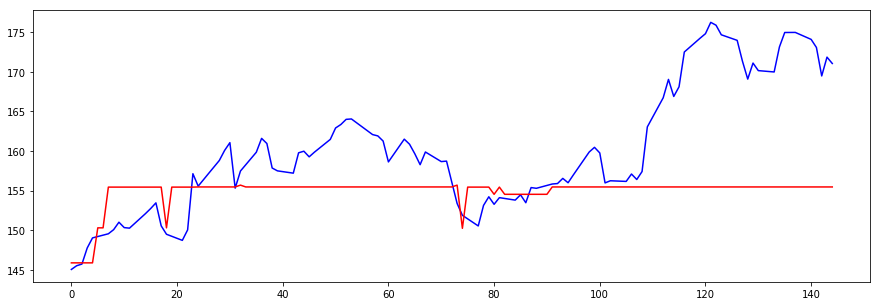

In [371]:
plt.plot(y_t, color='blue')
plt.plot(actual, color='red')
plt.show()

In [70]:
df_arima = finalData['Close']
df_arima.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11',
               '2010-01-12', '2010-01-13',
               ...
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18'],
              dtype='datetime64[ns]', length=2876, freq='D')

In [71]:
model = ARIMA(df_arima, order=(5,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2875
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -4234.806
Method:                       css-mle   S.D. of innovations              1.056
Date:                Sat, 18 Nov 2017   AIC                           8485.612
Time:                        19:07:59   BIC                           8533.322
Sample:                    01-05-2010   HQIC                          8502.810
                         - 11-18-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0486      0.021      2.316      0.021       0.007       0.090
ar.L1.D.Close    -0.1764      0.210     -0.840      0.401      -0.588       0.235
ar.L2.D.Close     0.0312      0.025     

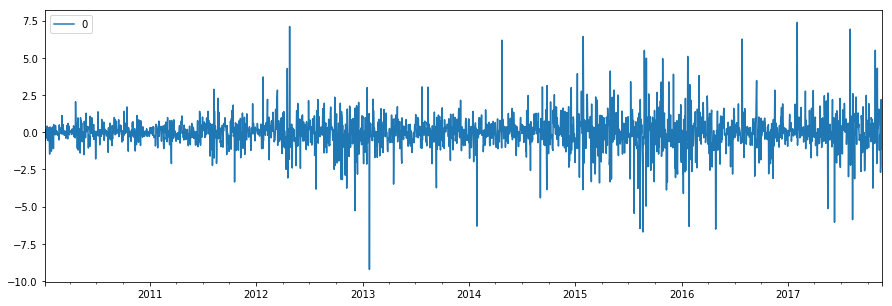

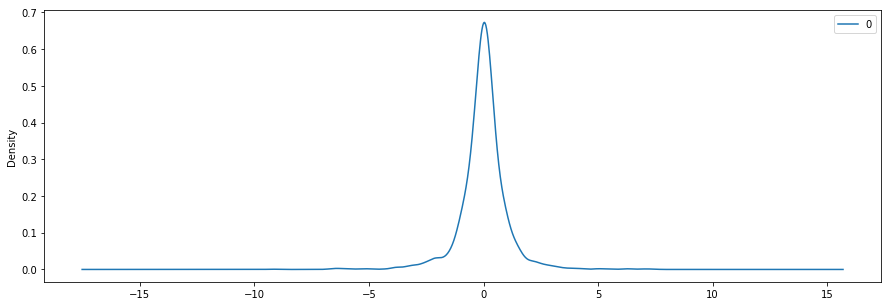

                 0
count  2875.000000
mean     -0.000004
std       1.055703
min      -9.219611
25%      -0.366320
50%       0.020891
75%       0.394649
max       7.387389


In [72]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Test MSE: 1.503


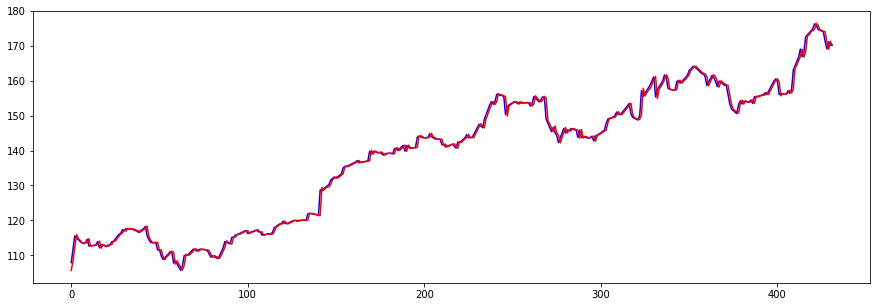

In [73]:
X = df_arima.values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)): 
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test, color='blue')
plt.plot(predictions, color='red')
plt.show()

In [45]:
# from sklearn import preprocessing

# finalDataNorm = preprocessing.normalize(finalData, norm='l2', axis=1)

In [46]:
# len(finalDataNorm[0])

14

In [47]:
# writeDF = pd.DataFrame(finalDataNorm)

In [49]:
# # writeDF.columns = ['open', 'high', 'low', 'close','adj close','volume','prev_diff','close_50_sma','10_day_volatility', \
#                    'sm_open','sm_high','sm_low','sm_close','sm_adj_close','sm_volume','sm_prev_diff','sm_close_50_sma',\
#                    'sm_10_day_volatility']

In [51]:
# writeDF.head(5)

In [52]:
# writeDF.to_csv('./aaplNorm.csv')

In [53]:
# finalData.to_csv('./aapl.csv')

In [54]:
# writeDF.insert(0, "date", finalData.index)

In [ ]:
# def applyTimeLag(dataset, lags, delta):
#     maxLag = max(lags)

#     columns = dataset.columns[::(2*max(delta)-1)]
#     for column in columns:
#         newcolumn = column + str(maxLag)
#         dataset[newcolumn] = dataset[column].shift(maxLag)

#     return dataset.iloc[maxLag:-1, :]


In [ ]:
# maxdelta = 30
# delta = range(8, maxdelta)

# high_value = 365
# high_value = min(high_value, writeDF.shape[0] - 1)

# writeDF = applyTimeLag(writeDF, [high_value], delta)

In [55]:
# writeDF.head(5)

In [ ]:
# import numpy as np

# index = int(np.floor(writeDF.shape[0]*0.95))
# train, test = writeDF[:index], writeDF[index:]
# print('Size of train set: ', train.shape)
# print('Size of test set: ', test.shape)

In [ ]:
# train.head(5)

In [ ]:
# X_train = train.loc[:, train.columns != 'close']
# X_train = X_train.loc[:, X_train.columns != 'date']
# X_train = X_train.loc[:, X_train.columns != 'date365']
# y_train = finalData['close'][:index]

In [ ]:
# X_train.head(5)

In [ ]:
# y_train.head(5)

In [ ]:
# X_test = test.loc[:, test.columns != 'close']
# X_test = X_test.loc[:, X_test.columns != 'date']
# X_test = X_test.loc[:, X_test.columns != 'date365']
# y_test = finalData['close'][index:]

In [ ]:
# y_test.shape

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

# # regr = RandomForestRegressor(n_estimators=10)
# # regr.fit(X_train, y_train)

# regr = BaggingRegressor()
# regr.fit(X_train, y_train)

In [ ]:
# print(regr.feature_importances_)

In [ ]:
# print(regr.predict(X_test)[0:6])

In [ ]:
# y_test.head(5)

In [ ]:
# # x = writeDF[:,0:9]
# x = writeDF.iloc[:,0:16]
# x = x.set_index('date')

In [ ]:
# x.close = finalData.close

In [ ]:
# x = x.sort_index()
# x.head(5)

In [ ]:
# index = int(np.floor(x.shape[0]*0.90))
# train, test = x[:index], x[index:]
# print('Size of train set: ', train.shape)
# print('Size of test set: ', test.shape)

In [ ]:
# X_train = train.loc[:, train.columns != 'close']
# y_train = train['close']
# X_test = test.loc[:, test.columns != 'close']
# y_test = test['close']

In [ ]:
# X_train.head(5)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

# regr = RandomForestRegressor(n_estimators=10, random_state = 10)
# regr.fit(X_train, y_train)

# regr = BaggingRegressor()
# regr.fit(X_train, y_train)


In [ ]:
# predictions = regr.predict(X_test)

In [ ]:
# error = mean_squared_error(y_test, predictions)
# plt.plot(y_test, color='blue')
# # plt.plot(prediction, color='red')
# # plt.show()
# error

In [ ]:
# y_t = []
# for item in y_test:
#     y_t.append(item)

In [ ]:
# plt.plot(y_t, color='blue')
# plt.plot(predictions, color='red')
# plt.show()

In [ ]:
# predictions[0:9]

In [ ]:
# y_t[0:9]

In [74]:
y = finalData
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039


In [76]:
y["20d"] = np.round(y["Close"].rolling(window = 20, center = False).mean(), 2)
z = y['Close'][0:19]
y['20d'][0:19] = z

In [79]:
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,20d,50d
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857,30.572857
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713,30.625713
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571,30.138571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857,30.082857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858,30.282858


In [78]:
# y["50d"] = np.round(y["Close"].rolling(window = 50, center = False).mean(), 2)
# z1 = y['Close'][0:49]
# y['50d'][0:49] = z1

In [30]:
# y["100d"] = np.round(y["Close"].rolling(window = 100, center = False).mean(), 2)
# z1 = y['Close'][0:99]
# y['100d'][0:99] = z1

In [31]:
# y["200d"] = np.round(y["Close"].rolling(window = 200, center = False).mean(), 2)
# z1 = y['Close'][0:199]
# y['200d'][0:199] = z1

In [80]:
import math

def ten_day_volatility_new(dataframe):
    volatility = dataframe['Close'].rolling(window=10,center=False).std(ddof=0)
    # daily_pct_change = stockstats_df['close'] / stockstats_df['close'].shift(1) - 1
    # volatility2 = daily_pct_change.rolling(window=10,center=False).std(ddof=0) * math.sqrt(10)
    top = dataframe[0:9]
    top_vol = top['Close'].rolling(window=2,center=False).std(ddof=0)
    top_vol[0] = 0
    volatility[0:9] = top_vol
    return volatility

In [81]:
y['10dv'] = ten_day_volatility_new(y)

In [82]:
y.head(5)

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,20d,50d,10dv
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400.0,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857,30.572857,0.000000
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200.0,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713,30.625713,0.026428
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000.0,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571,30.138571,0.243571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800.0,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857,30.082857,0.027857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,111902700.0,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858,30.282858,0.100001


In [36]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# y[['Open', 'High', 'Low', 'Adj Close', 'Volume', '50d']] = scaler.fit_transform(y[['Open', 'High', 'Low', 'Adj Close', 'Volume', '50d']])

In [83]:
# y.head(5)

In [102]:
a = stockMarketDataInterpolated
a["50d"] = np.round(a["Close"].rolling(window = 50, center = False).mean(), 2)
z1 = a['Close'][0:49]
a['50d'][0:49] = z1

In [103]:
a['10dv'] = ten_day_volatility_new(a)

In [104]:
a.head(5)

,Open,High,Low,Close,Adj Close,Volume,50d,10dv
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,1132.989990,0.000000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,1136.520020,1.765015
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,1137.140015,0.309998
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,1141.689941,2.274963
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,1144.979980,1.645019


In [108]:
a[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume', '50d']] = scaler.fit_transform(a[['Open', 'High', 'Low', 'Close','Adj Close', 'Volume', '50d']])

In [110]:
a.columns = ['sm_open', 'sm_high', 'sm_low', 'sm_close', 'sm_adj_close', 'sm_volume', 'sm_50d', 'sm_10dv']

In [111]:
a.head(5)

,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_50d,sm_10dv
2010-01-04,0.056831,0.064524,0.067090,0.070244,0.070244,0.309232,0.050515,0.000000
2010-01-05,0.067122,0.066289,0.075409,0.072490,0.072490,0.152825,0.052854,1.765015
2010-01-06,0.069072,0.067925,0.078133,0.072885,0.072885,0.411523,0.053264,0.309998
2010-01-07,0.069430,0.070016,0.076463,0.075779,0.075779,0.442590,0.056279,2.274963
2010-01-08,0.072146,0.071889,0.079575,0.077872,0.077872,0.350741,0.058458,1.645019


In [278]:
f = pd.concat([y, a], axis=1)

In [279]:
def applyTimeLag(dataset, lags, delta):
    maxLag = max(lags)

    columns = dataset.columns[::(2*max(delta)-1)]
    for column in columns:
        newcolumn = column + str(maxLag)
        dataset[newcolumn] = dataset[column].shift(maxLag)

    return dataset.iloc[maxLag:-1, :]


In [280]:
maxdelta = 30

delta = range(8, maxdelta)
print('Delta days accounted: ', max(delta))

high_value = 365
high_value = min(high_value, f.shape[0] - 1)

lags = range(high_value, 30)
print('Maximum time lag applied', high_value)

print('Size of data frame: ', f.shape)

#Move the Open Values behind by one dataset.
f.Open = f.Open.shift(-1)

f = applyTimeLag(f, [high_value], delta)

('Delta days accounted: ', 29)
('Maximum time lag applied', 365)
('Size of data frame: ', (2876, 17))


In [368]:
f = f.drop(['sm_50d', 'sm_10dv'], axis=1)

In [392]:
import numpy as np

index = int(np.floor(f.shape[0]*0.95))
train, test = f[:index], f[index:]
print('Size of train set: ', train.shape)
print('Size of test set: ', test.shape)

('Size of train set: ', (2384, 16))
('Size of test set: ', (126, 16))


In [393]:
X_train = train.loc[:, train.columns != 'Close']
y_train = train['Close']

In [394]:
X_train.shape
y_train.shape

(2384,)

In [395]:
X_test = test.loc[:, test.columns != 'Close']
y_test = test['Close']
y_test.shape

(126,)

In [396]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor

# regr = RandomForestRegressor(n_estimators=1, random_state = 10, min_samples_split=2)
# regr.fit(X_train, y_train)

regr = GradientBoostingRegressor()
regr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [397]:
predictions = regr.predict(X_test)

In [398]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
error

55.407923755658018

In [399]:
y_t = []
for item in y_test:
    y_t.append(item)

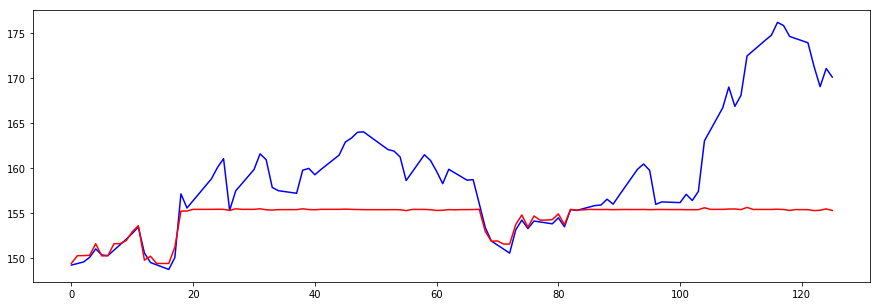

In [400]:
plt.plot(y_t, color='blue')
plt.plot(predictions, color='red')
plt.show()

/Users/manika/anaconda3/envs/stock/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [71]:
svmD = finalData

In [73]:
svmD["50d"] = np.round(svmD["Close"].rolling(window = 50, center = False).mean(), 2)
z1 = svmD['Close'][0:49]
svmD['50d'][0:49] = z1

In [74]:
svmD

,Open,High,Low,Close,Adj Close,Volume,prev_diff,sm_open,sm_high,sm_low,sm_close,sm_adj_close,sm_volume,sm_prev_diff,50d
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,1.234324e+08,0.000000,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3.991400e+09,0.000000,30.572857
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,1.504762e+08,0.052856,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2.491020e+09,3.530030,30.625713
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,1.380400e+08,-0.487142,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4.972660e+09,0.619995,30.138571
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,1.192828e+08,-0.055714,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5.270680e+09,4.549926,30.082857
2010-01-08,30.042856,30.285715,29.865715,30.282858,27.146566,1.119027e+08,0.200001,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4.389590e+09,3.290039,30.282858
2010-01-09,30.161904,30.333334,29.836667,30.193810,27.066742,1.131209e+08,-0.089048,1142.333334,1146.840007,1138.153321,1145.646647,1145.646647,4.344987e+09,0.666667,30.193810
2010-01-10,30.280952,30.380953,29.807620,30.104763,26.986917,1.143392e+08,-0.089048,1144.146647,1148.289998,1140.086670,1146.313313,1146.313313,4.300383e+09,0.666667,30.104763
2010-01-11,30.400000,30.428572,29.778572,30.015715,26.907093,1.155574e+08,-0.089048,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4.255780e+09,0.666667,30.015715
2010-01-12,29.884285,29.967142,29.488571,29.674286,26.601023,1.486149e+08,-0.341429,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4.716160e+09,-10.760009,29.674286
2010-01-13,29.695715,30.132856,29.157143,30.092857,26.976244,1.514730e+08,0.418571,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4.170360e+09,9.460083,30.092857


In [75]:
import numpy as np

index = int(np.floor(svmD.shape[0]*0.95))
train, test = svmD[:index], svmD[index:]
print('Size of train set: ', train.shape)
print('Size of test set: ', test.shape)

Size of train set:  (2732, 15)
Size of test set:  (144, 15)


In [76]:
X_train = train.loc[:, train.columns != 'Close']
y_train = train['Close']

In [77]:
X_test = test.loc[:, test.columns != 'Close']
y_test = test['Close']
y_test.shape

(144,)

In [78]:
'''
    Running Support Vector Regression Model.
'''
from __future__ import print_function

import os
import sys
import pandas as pd
from sklearn.svm import SVR
from sklearn import cross_validation
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cross_validation import train_test_split

def convert_to_integer(dt_time):
    return 10000*dt_time.year + 1000*dt_time.month + dt_time.day

def svm(file_dataframe, test_size=0.2, cols=['date', 'open']):
#     '''
#         Run Logistic Regression
#     '''

#     print('Loading data...')

#     if 'date' in file_dataframe:
#         file_dataframe['new_col'] = pd.to_datetime(file_dataframe['date']).astype(datetime)
#         #file_dataframe['date'] = pd.to_datetime(file_dataframe['date'])
#         file_dataframe['new_col'].apply(lambda dt_time:10000*dt_time.year + 1000*dt_time.month + dt_time.day).astype(int)

#     print(file_dataframe['new_col'])

#     X = file_dataframe['open']
#     y = file_dataframe['new_col']

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    #svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = SVR(kernel='linear', C=1)
    #svr_poly = SVR(kernel='poly', C=1e3, degree=2)

    #parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

    #loo = cross_validation.LeaveOneOut(len(y_train) - 1)
    #clf = grid_search.GridSearchCV(svr_rbf, parameters)
    scores = []

    #svr_rbf.fit(X_train, y_train)
    svr_lin.fit(X_train, y_train)
    #svr_poly.fit(X_train, y_train)

    #scores.append(cross_validation.cross_val_score(svr_rbf, \
    #    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    scores.append(cross_validation.cross_val_score(svr_lin, \
        X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    #scores.append(cross_validation.cross_val_score(svr_poly, \
    #    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())
    
    return scores

In [79]:
svr_lin = SVR(kernel='linear', C=1)

In [ ]:
scores = []

svr_lin.fit(X_train, y_train)

predictions = svr_lin.predict(X_test)

#svr_poly.fit(X_train, y_train)

#scores.append(cross_validation.cross_val_score(svr_rbf, \
#    X_test, y_test, scoring='mean_squared_error', cv=loo).mean())


In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(y_test, predictions)
error

In [ ]:
y_t = []
for item in y_test:
    y_t.append(item)

In [ ]:
plt.plot(y_t, color='blue')
plt.plot(predictions, color='red')
plt.show()